In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt
from statsmodels.tsa.stattools import adfuller # Test de Dickey-Fuller (estacionaridad)
from statsmodels.tsa.statespace.sarimax import SARIMAX # modelo para el forecating
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Función de autocorrelación/ autocorrelación parcial (parámetros modelo ARIMA)
from sklearn.metrics import r2_score
from pmdarima.arima import auto_arima


Base de datos de la temperatura de la Tierra por Paises y Global. Base de datos obtenida de Kaggle (https://www.kaggle.com/sachinsarkar/climate-change-global-temperature-data)

In [2]:
# Leemos la tabla con la que vamos a trabajar y renombramos las columnas

file_path="tablas_ini/Kaggledata_GlobalLandTemperaturesByCountry.csv"
data_GobalTemp_Country=pd.read_csv(file_path,converters={"dt":pd.to_datetime})
data_GobalTemp_Country.rename(columns={"dt": "fecha","AverageTemperature": "Temp. promedio", 
                     "AverageTemperatureUncertainty":"Error","Country":"Pais"},inplace=True)

data_GobalTemp_Country=data_GobalTemp_Country.set_index("fecha")

In [3]:
# Listamos todos los paises de los que hay medidas de temperatura
lista_paises =pd.unique(data_GobalTemp_Country["Pais"]).tolist()
print(lista_paises)

['Åland', 'Afghanistan', 'Africa', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua And Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Baker Island', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bonaire, Saint Eustatius And Saba', 'Bosnia And Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', "Côte D'Ivoire", 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Christmas Island', 'Colombia', 'Comoros', 'Congo (Democratic Republic Of The)', 'Congo', 'Costa Rica', 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic', 'Denmark (Europe)', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Europe', 'Falkland Islan

In [4]:
# Función para selecionar los datos del Pais que nos interesa y renombrar las columnas con el nombre del pais
def crear_lista(df,pais):
    df=df.loc[((df['Pais'] == pais))]
    df.drop("Pais",axis=1,inplace=True)
    df.rename(columns={"Temp. promedio": "Temp. "+str(pais),"Error": "Error "+str(pais)},inplace=True)
    return df

In [5]:
# Selecionamos los datos de los continentes y los juntamos todos en un único DataFrame
data_Asia=crear_lista(data_GobalTemp_Country,"Asia")
data_Europe=crear_lista(data_GobalTemp_Country,"Europe")
data_Africa=crear_lista(data_GobalTemp_Country,"Africa")
data_North_America=crear_lista(data_GobalTemp_Country,"North America")
data_Oceania=crear_lista(data_GobalTemp_Country,"Oceania")
data_South_America=crear_lista(data_GobalTemp_Country,"South America")


data = pd.concat([data_Asia, data_Europe,data_Africa,data_North_America,
                 data_Oceania,data_South_America], axis=1)

/home/belen/.local/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/belen/.local/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [6]:
# Nos quedamos solo con los datos desde 1860, antes no hay datos de todos los contienentes y de los que hay,
# algunos no son muy buenos
data = data[~(data.index < '1880-01-01')]

In [7]:
# Extraemos de la fecha por un lado los meses y por otro los años, guardamos la información de dos nuevas columnas
data_month=data.reset_index()
data_month['month'] = data_month['fecha'].dt.month

data_month['year'] = data_month['fecha'].dt.year

In [8]:
# Función para calcular la temperatura máxima, mínima y promedio de cada año 
def cal_sts(pais):
    data_sts["max. "+str(pais)]=data_month.groupby(['year'], sort=False)['Temp. '+str(pais)].max()
    data_sts["min. "+str(pais)]=data_month.groupby(['year'], sort=False)['Temp. '+str(pais)].min()
    data_sts["avg. "+str(pais)]=data_month.groupby(['year'], sort=False)['Temp. '+str(pais)].mean()
    return data_sts

In [9]:
# Creamos una nueva tabla con los datos de temp. máxima, mínima y promedio por año para cada Contiente

data_sts=pd.DataFrame(columns=["max. Asia","min. Asia","avg. Asia",
                               "max. Europe","min. Europe","avg. Europe",
                               "max. Africa","min. Africa","avg. Africa",
                               "max. North America","min. North America","avg. North America",
                               "max. Oceania","min. Oceania","avg. Oceania",
                               "max. South America","min. South America","avg. South America"])

data_sts=cal_sts("Asia")
data_sts=cal_sts("Europe")
data_sts=cal_sts("Africa")
data_sts=cal_sts("North America")
data_sts=cal_sts("Oceania")
data_sts=cal_sts("South America")


In [10]:
# Calculamos los promedios móvil de la temp. mínima, máxima y promédio anual que acabamos de calcular. 
# También calculamos los promedios móviles de la temperatura medida mensualmente (datos originales) 
vent=12

data_sts_temp=data_sts.fillna(0)
data_sts_mov_avg=data_sts_temp.rolling(vent).mean()

data_temp=data.fillna(0)
data_mov_avg=data_temp.rolling(vent).mean()
data_mov_std=data_temp.rolling(vent).std()

In [11]:
# Convertimos a formato fecha el indice de la tabla de temp. max, min, y avg.
data_sts_mov_avg.index = pd.to_datetime(data_sts_mov_avg.index,format='%Y')

data_sts.index = pd.to_datetime(data_sts.index,format='%Y')

#### Estadistica de los datos

In [12]:
# estadistica de los datos
data.describe()

Temp. Asia   Error Asia  Temp. Europe  Error Europe  Temp. Africa  \
count  1604.000000  1604.000000   1604.000000   1604.000000   1604.000000   
mean      7.541307     0.245204      8.049480      0.269923     24.148696   
std      10.164543     0.127935      7.172616      0.145537      1.753997   
min     -10.707000     0.055000     -7.549000      0.076000     19.667000   
25%      -1.729750     0.148000      1.331750      0.173750     22.822500   
50%       8.218500     0.208000      7.840500      0.232000     24.876500   
75%      18.151250     0.311000     14.969000      0.317250     25.478250   
max      22.635000     0.847000     20.582000      1.488000     27.126000   

       Error Africa  Temp. North America  Error North America  Temp. Oceania  \
count   1604.000000          1605.000000          1605.000000    1604.000000   
mean       0.292353             2.305250             0.331782      21.532804   
std        0.170896             9.973288             0.209523       4.582548   
min        0.077000           -15.647000             0.084000      12.943000   
25%        0.173000            -7.333000             0.179000      17.201250   
50%        0.231000             2.483000             0.252000      22.029000   
75%        0.350250            12.429000             0.439000      25.848250   
max        1.454000            17.944000             1.509000      29.154000   

       Error Oceania  Temp. South America  Error South America  
count    1604.000000          1604.000000          1604.000000  
mean        0.304893            21.915201             0.319228  
std         0.195087             1.582349             0.201131  
min         0.078000            18.055000             0.066000  
25%         0.177000            20.639250             0.174000  
50%         0.239500            22.186000             0.243000  
75%         0.357250            23.271250             0.403500  
max         1.956000            24.820000             1.214000

array([[<AxesSubplot:title={'center':'Temp. Asia'}>,
        <AxesSubplot:title={'center':'Error Asia'}>],
       [<AxesSubplot:title={'center':'Temp. Europe'}>,
        <AxesSubplot:title={'center':'Error Europe'}>],
       [<AxesSubplot:title={'center':'Temp. Africa'}>,
        <AxesSubplot:title={'center':'Error Africa'}>],
       [<AxesSubplot:title={'center':'Temp. North America'}>,
        <AxesSubplot:title={'center':'Error North America'}>],
       [<AxesSubplot:title={'center':'Temp. Oceania'}>,
        <AxesSubplot:title={'center':'Error Oceania'}>],
       [<AxesSubplot:title={'center':'Temp. South America'}>,
        <AxesSubplot:title={'center':'Error South America'}>]],
      dtype=object)

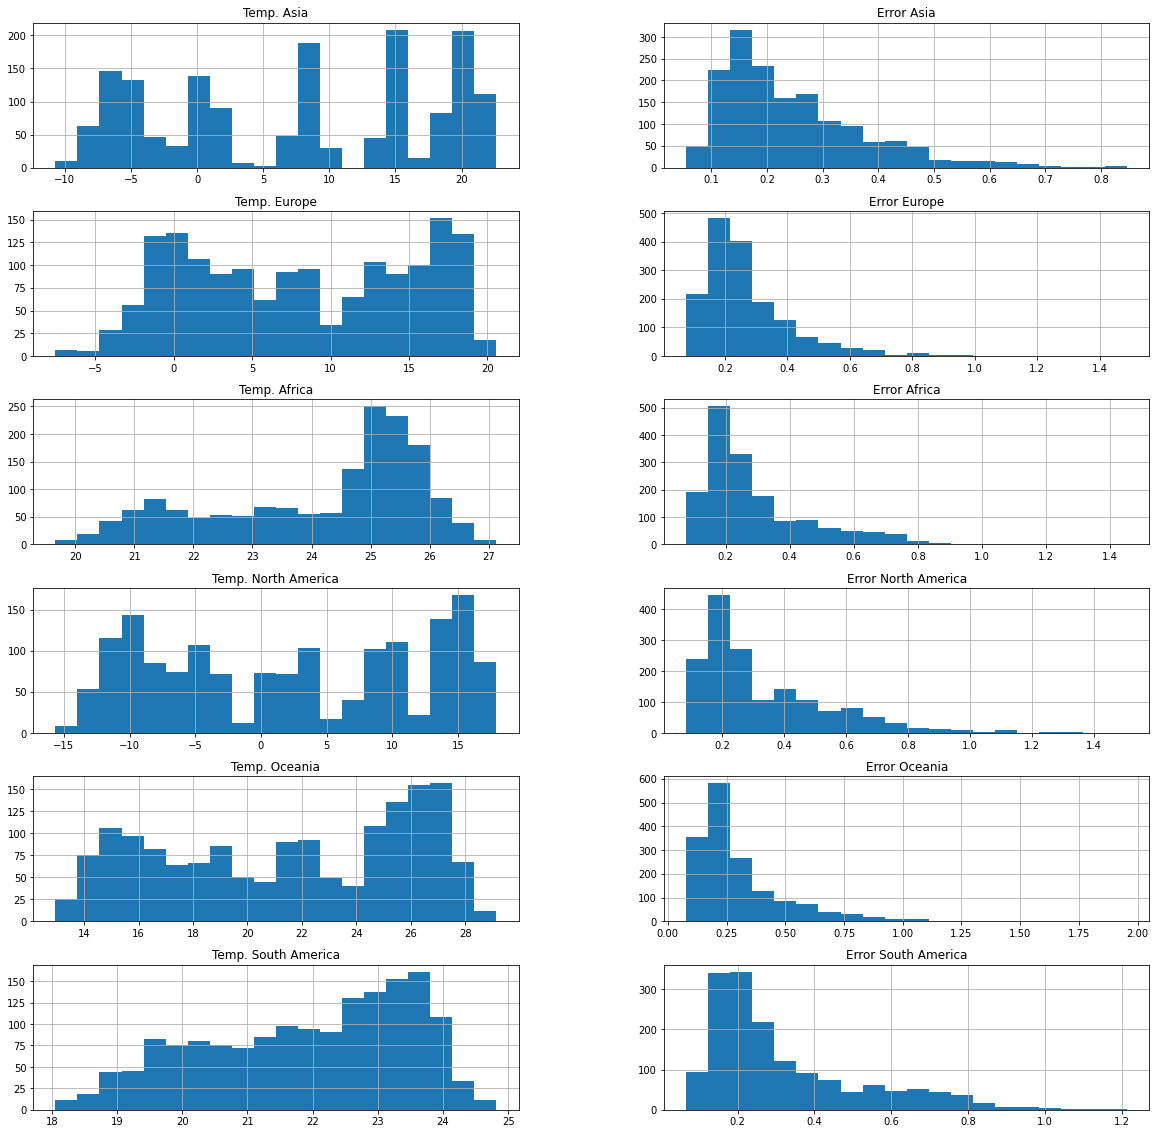

In [13]:
# Histograma de los datos
data.hist(bins=20, figsize=(20, 20), layout=(6, 2))

#### Distribución de los datos por meses

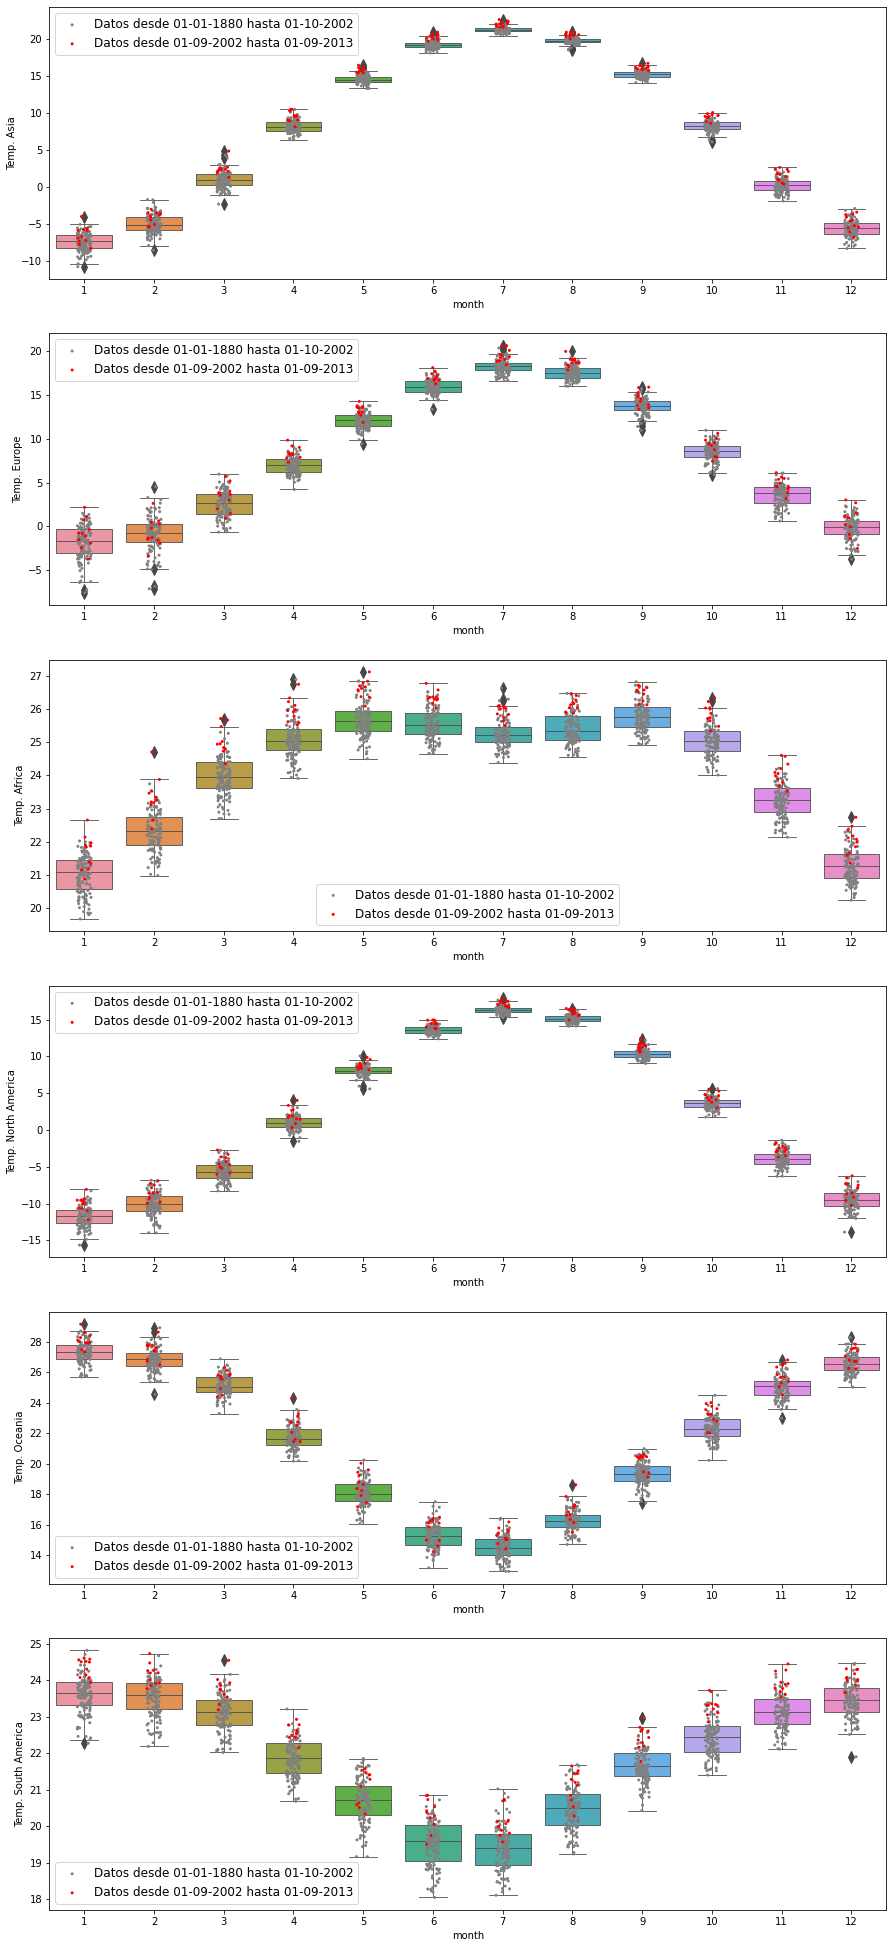

In [14]:
# Boxplot de los datos de cada continente para cada mes + scatterplot de las temperaturas medidas en cada mes
# Hemos representado las temperaturas de los últimos 11 años en otro color para ver si están fuera de la normalidad

fig, ax = plt.subplots(nrows=6, ncols=1,figsize=(15,35),sharex=False)

a=["Temp. Asia","Temp. Europe","Temp. Africa","Temp. North America","Temp. Oceania","Temp. South America"]
pos=['upper left','upper left',"lower center",'upper left',"lower left","lower left"]

for i in range(len(a)):
    sns.stripplot(x=data_month["month"][:-132], y=data_month[a[i]][:-132],color="grey",ax=ax[i]
                  ,size=3,jitter=True,label="Datos desde "+str(data_month["fecha"].iloc[0].strftime("%d-%m-%Y"))+
                  " hasta "+str(data_month["fecha"].iloc[-132].strftime("%d-%m-%Y")))
    sns.stripplot(x=data_month["month"][-133:], y=data_month[a[i]][-133:],color="red",ax=ax[i]
                  ,size=3,jitter=True,label="Datos desde "+str(data_month["fecha"].iloc[-133].strftime("%d-%m-%Y"))+
                  " hasta "+str(data_month["fecha"].iloc[-1].strftime("%d-%m-%Y")))
    sns.boxplot(x=data_month["month"], y=data_month[a[i]],ax=ax[i],fliersize=8,linewidth=0.8)
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend((handles[i] for i in [1,13]), (labels[i] for i in [1,13]),loc=pos[i],fontsize=12)

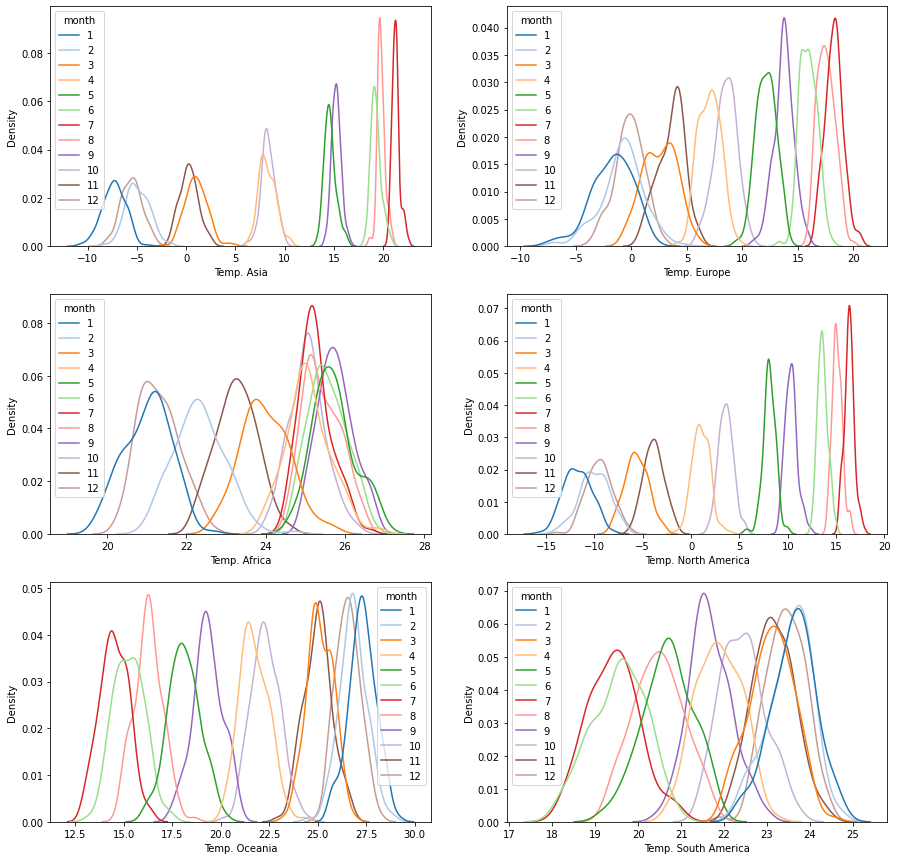

In [15]:
# Representación de la distrubución (KDE) de la temperatura medida cada mes para los diferentes contienentes 
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

a=["Temp. Asia","Temp. Europe","Temp. Africa","Temp. North America","Temp. Oceania","Temp. South America"]

for i in range(len(a)):
    ax = fig.add_subplot(3, 2, i+1)
    sns.kdeplot(data=data_month,x=a[i],hue="month",palette='tab20',ax=ax)


#### Representación de los datos

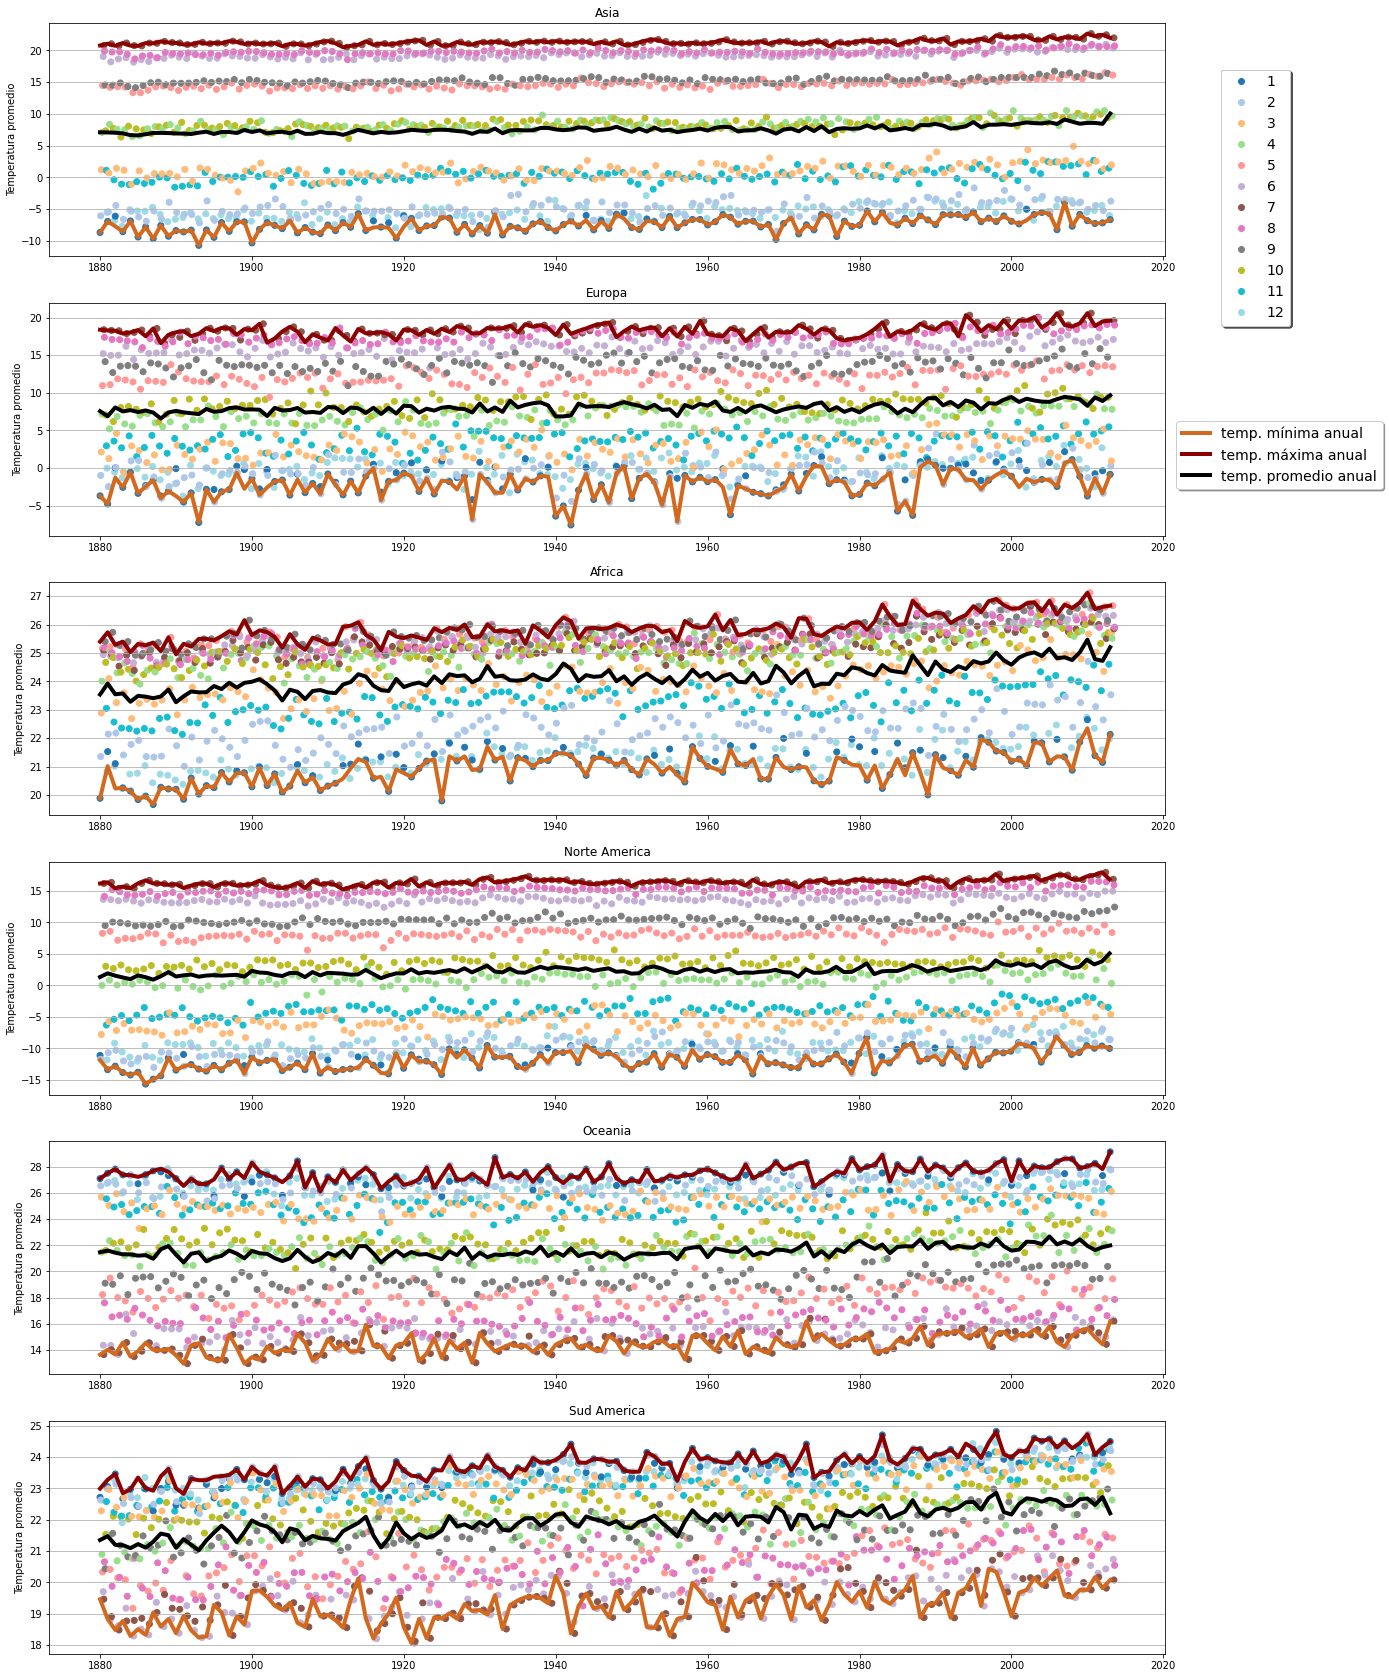

In [16]:
# Representamos todas las temperaturas medidas mensualmente junto con la temperaturas mínimas, máximas y 
# promedios calculadas para cada año de cada Continente

fig, ax = plt.subplots(nrows=6, ncols=1,figsize=(20,30),sharex=False)

a=["Temp. Asia","Temp. Europe","Temp. Africa","Temp. North America","Temp. Oceania","Temp. South America"]
titulo=["Asia","Europa","Africa","Norte America","Oceania","Sud America"]
b=["Asia","Europe","Africa","North America","Oceania","South America"]

plot_lines = []

for i in range(len(a)):
    scatter = ax[i].scatter(data_month["fecha"][:],data_month[a[i]][:],c=data_month["month"][:],cmap='tab20')
    plot1 = ax[i].plot(data_sts.index,data_sts["min. "+str(b[i])],"-",label="temp. mínima anual",c="chocolate",lw=4)
    plot2 = ax[i].plot(data_sts.index,data_sts["max. "+str(b[i])],"-",label="temp. máxima anual",c="darkred",lw=4)
    plot3 = ax[i].plot(data_sts.index,data_sts["avg. "+str(b[i])],"-",label="temp. promedio anual",c="black",lw=4)

    ax[i].set_title(titulo[i])
    ax[i].yaxis.grid()
    ax[i].set_ylabel('Temperatura promedio')

    
    legend1 = ax[0].legend(*scatter.legend_elements(),loc=(1.05,-0.30), fancybox=True, shadow=True,fontsize=14)
    ax[0].add_artist(legend1)
    
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles, labels, loc=(1.01,-1),fontsize=14, fancybox=True, shadow=True)
#     ax[0].get_legend().set_title("Promedios móviles \n con ventana de "+str(vent)+": \n",prop={'size':16})


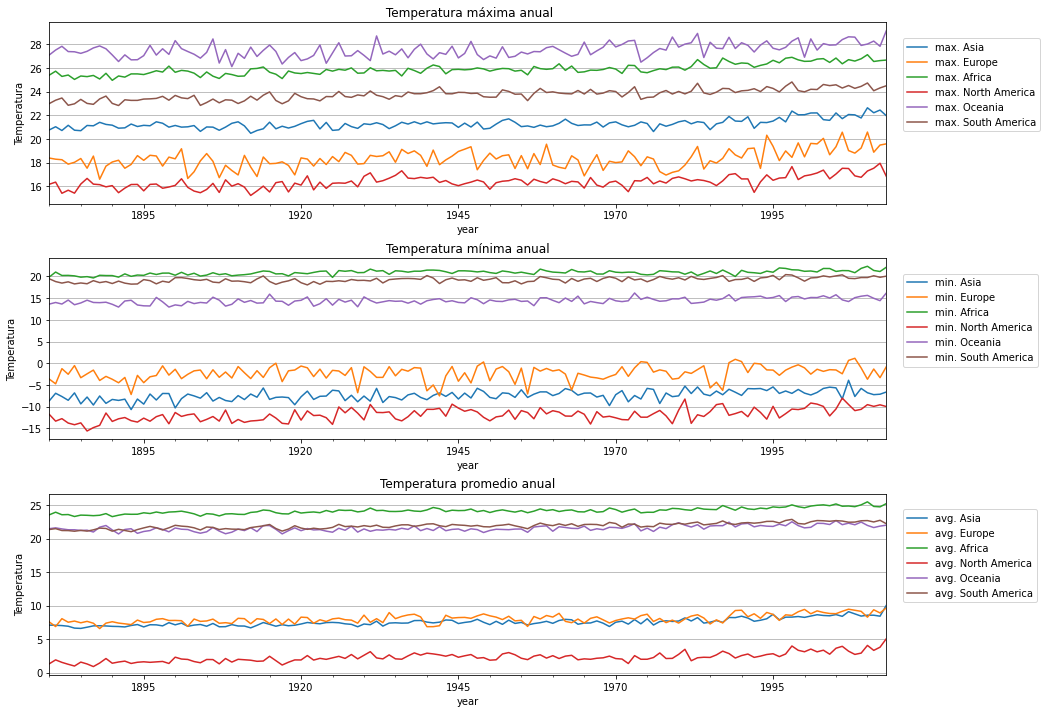

In [17]:
# Representación de la temperatura mínima, máxima y promedio por año para cada contienente

fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(15,12),sharex=False)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

a=["max.","min.","avg."]
b=[" Temperatura máxima anual", "Temperatura mínima anual","Temperatura promedio anual"]


for i in range(len(a)):
    
    data_sts[[str(a[i])+" Asia",str(a[i])+" Europe",str(a[i])+" Africa",
             str(a[i])+" North America",str(a[i])+" Oceania",str(a[i])+" South America"]].plot(ax=ax[i],title=b[i])
#     data_sts_mov_avg[[str(a[i])+" Asia",str(a[i])+" Europe",str(a[i])+" Africa",
#              str(a[i])+" North America",str(a[i])+" Oceania",str(a[i])+" South America"]].plot(ax=ax[i],title=b[i])
    ax[i].legend(loc=(1.02,0.4))
    ax[i].yaxis.grid()
    ax[i].set_ylabel('Temperatura')

#### Estudio de la estacionariedad -> forcasting

In [18]:
# Función en la que estimamos los diferentes parámetros y plots para hacer el estudio de la estacionaridad
def test_stacionary(df,df_month,df_mov_avg,df_mov_std,pais):
    print("-- "+str(pais)+":\n")
    # Representación de los datos junto con la estadística móvil
    scatter=ax.scatter(df_month["fecha"][:],df_month["Temp. "+str(pais)],c=df_month["month"][:],cmap='tab20')
    plot1=ax.plot(df_mov_avg.index[:],df_mov_avg["Temp. "+str(pais)][:],"-",label="promedio"
                     ,c="black",lw=3)
    plot1=ax.plot(df_mov_std.index[:],df_mov_std["Temp. "+str(pais)][:],"-",label="desviación std."
                     ,c="red",lw=3)
    ax.set_title(str(pais))
    ax.set_ylabel('Temperatura promedio')
    ax.yaxis.grid()
    
    legend1 = ax.legend(*scatter.legend_elements(),loc=(1.01,0.50), ncol=2, fancybox=True, shadow=True,fontsize=14)
    ax.add_artist(legend1)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc=(1.01,0),fontsize=14, fancybox=True, shadow=True)
    ax.get_legend().set_title("Estadisticas móviles \n con ventana de "+str(vent)+": \n",prop={'size':16})
    plt.show()
    
    # Cálculo de la media y desviación std en varias regiones de los datos
    X = df["Temp. "+str(pais)].dropna(axis=0)
    
    split = int(len(X) / 4)
    X1, X2,X3,X4 = X[0:split],X[split:split*2],X[split*2:split*3], X[split*3:]
    mean1,mean2,mean3,mean4 = X1.mean(), X2.mean(), X3.mean(), X4.mean()
    std1,std2,std3,std4 = X1.std(), X2.std(),X3.std(), X4.std()
    print("\n-- Estimación de media y desviación std dividiendo los datos en 4 regiones:")
    print('mean1={:.3f}, mean2={:.3f}, mean3={:.3f}, mean4={:.3f}'.format(mean1, mean2,mean3, mean4))
    print('desv. std1={:.3f}, desv. std2={:.3f}, desv. std3={:.3f}, desv. std4={:.3f}'.format(std1, std2,
                                                                                              std3, std4))
    
    # Test de Dickey-Fuller:
    dftest = adfuller(df["Temp. "+ str(pais)].dropna(axis=0), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print("\n-- Test de Dickey-Fuller:")
    print(dfoutput)  

-- Asia:



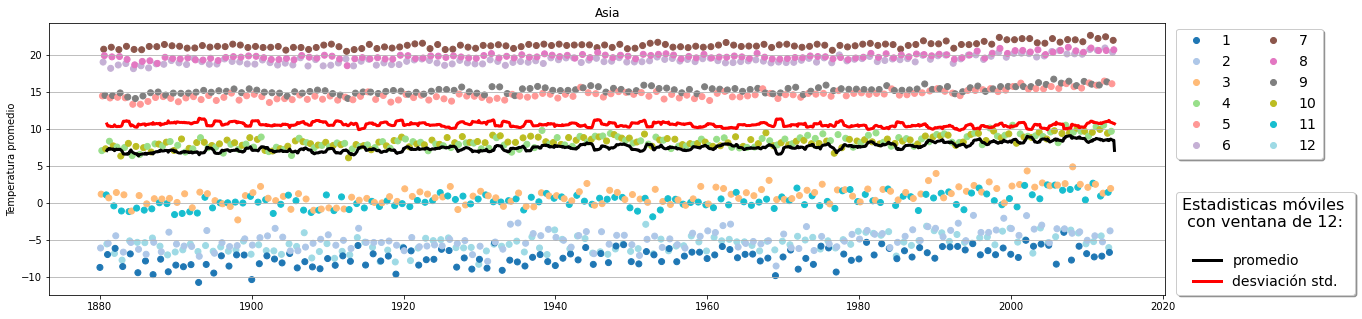


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=6.936, mean2=7.491, mean3=7.384, mean4=8.355
desv. std1=10.290, desv. std2=10.202, desv. std3=10.157, desv. std4=9.993

-- Test de Dickey-Fuller:
Test Statistic                   -1.983870
p-value                           0.293690
#Lags Used                       23.000000
Number of Observations Used    1580.000000
Critical Value (1%)              -3.434496
Critical Value (5%)              -2.863371
Critical Value (10%)             -2.567745
dtype: float64


In [19]:
# Estudio de estacionaridad para Asia
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,5),sharex=False)
test_stacionary(data,data_month,data_mov_avg,data_mov_std,"Asia")

-- Europe:



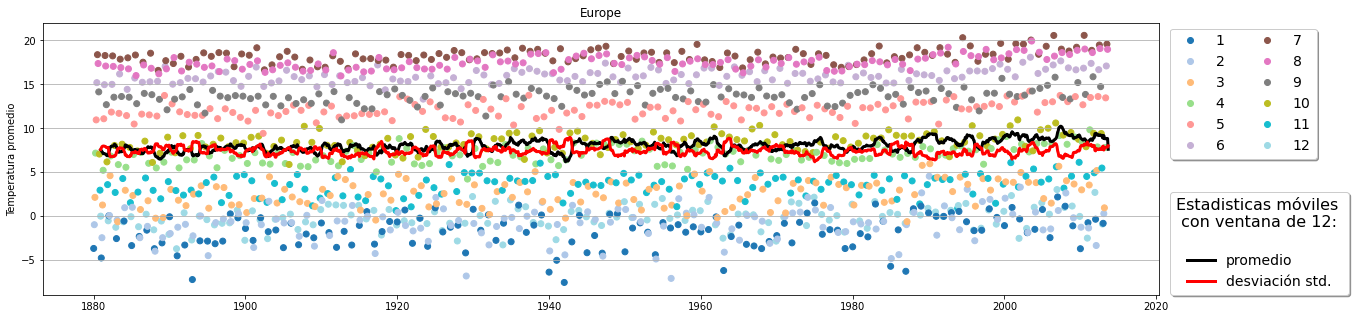


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=7.529, mean2=7.997, mean3=7.945, mean4=8.727
desv. std1=7.158, desv. std2=7.195, desv. std3=7.162, desv. std4=7.150

-- Test de Dickey-Fuller:
Test Statistic                   -3.633737
p-value                           0.005148
#Lags Used                       24.000000
Number of Observations Used    1579.000000
Critical Value (1%)              -3.434498
Critical Value (5%)              -2.863372
Critical Value (10%)             -2.567745
dtype: float64


In [20]:
# Estudio de estacionaridad para Europa
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,5),sharex=False)
test_stacionary(data,data_month,data_mov_avg,data_mov_std,"Europe")

-- Africa:



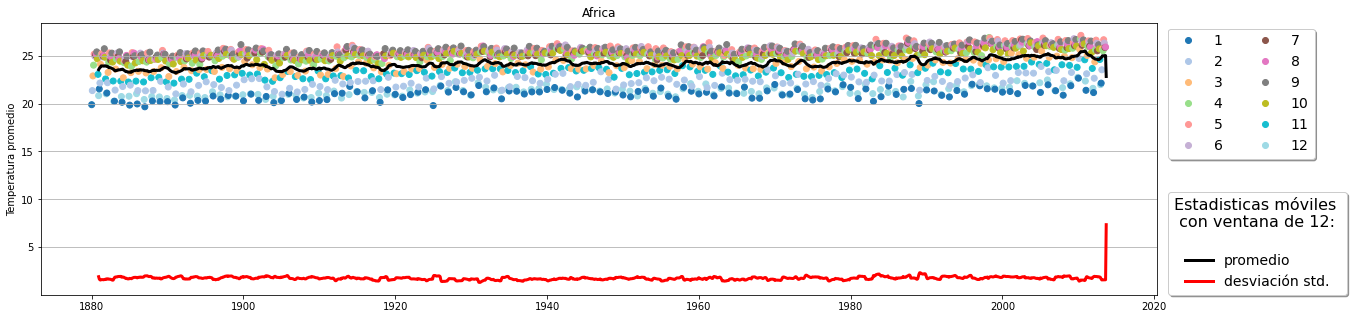


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=23.647, mean2=24.120, mean3=24.124, mean4=24.704
desv. std1=1.760, desv. std2=1.629, desv. std3=1.669, desv. std4=1.797

-- Test de Dickey-Fuller:
Test Statistic                   -2.241195
p-value                           0.191635
#Lags Used                       25.000000
Number of Observations Used    1578.000000
Critical Value (1%)              -3.434501
Critical Value (5%)              -2.863373
Critical Value (10%)             -2.567746
dtype: float64


In [21]:
# Estudio de estacionaridad para Africa
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,5),sharex=False)
test_stacionary(data,data_month,data_mov_avg,data_mov_std,"Africa")

-- North America:



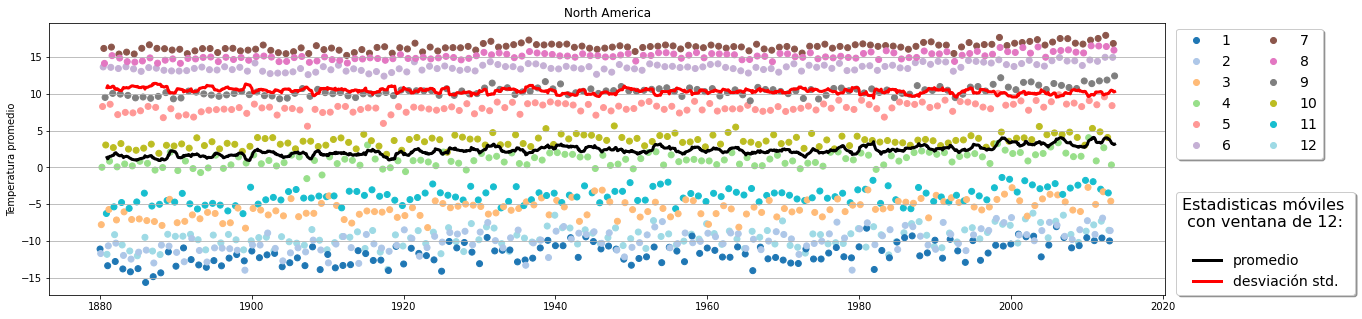


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=1.566, mean2=2.417, mean3=2.151, mean4=3.085
desv. std1=10.204, desv. std2=9.925, desv. std3=9.974, desv. std4=9.763

-- Test de Dickey-Fuller:
Test Statistic                   -2.835828
p-value                           0.053335
#Lags Used                       24.000000
Number of Observations Used    1580.000000
Critical Value (1%)              -3.434496
Critical Value (5%)              -2.863371
Critical Value (10%)             -2.567745
dtype: float64


In [22]:
# Estudio de estacionaridad para Norte America
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,5),sharex=False)
test_stacionary(data,data_month,data_mov_avg,data_mov_std,"North America")

-- Oceania:



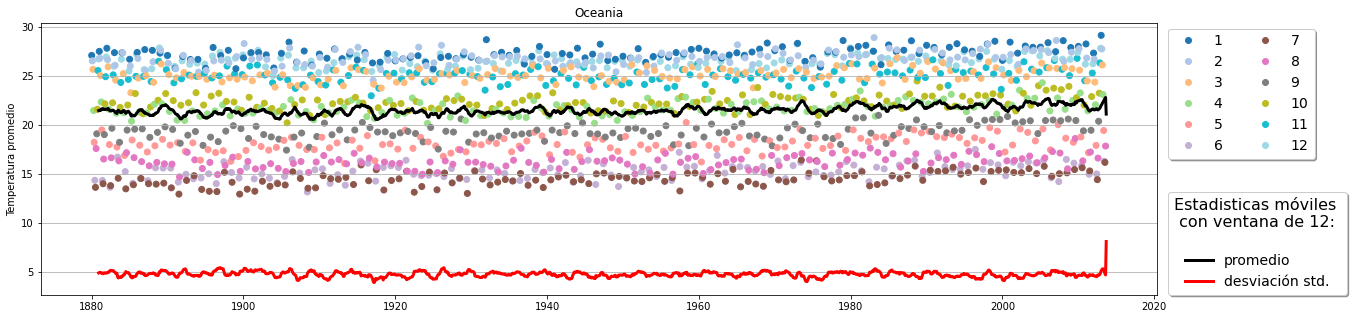


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=21.288, mean2=21.305, mean3=21.559, mean4=21.980
desv. std1=4.649, desv. std2=4.559, desv. std3=4.566, desv. std4=4.539

-- Test de Dickey-Fuller:
Test Statistic                   -3.905574
p-value                           0.001994
#Lags Used                       25.000000
Number of Observations Used    1578.000000
Critical Value (1%)              -3.434501
Critical Value (5%)              -2.863373
Critical Value (10%)             -2.567746
dtype: float64


In [23]:
# Estudio de estacionaridad para Oceania
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,5),sharex=False)
test_stacionary(data,data_month,data_mov_avg,data_mov_std,"Oceania")

-- South America:



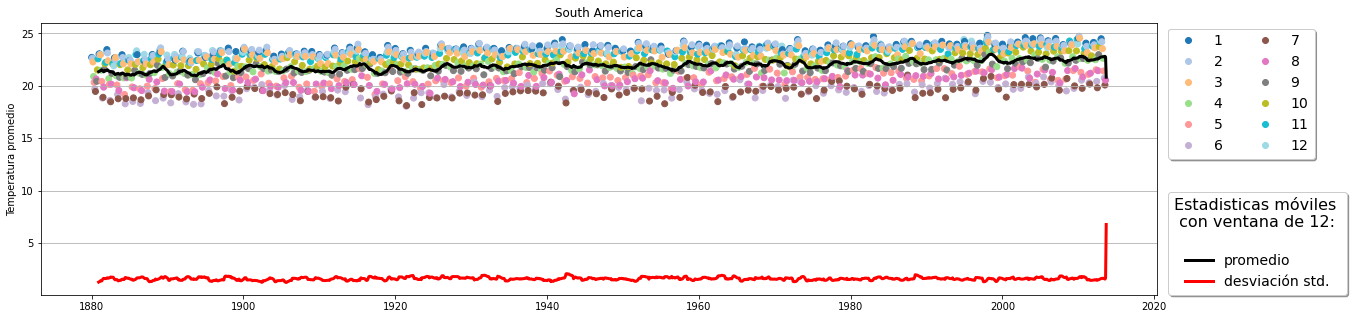


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=21.446, mean2=21.785, mean3=22.007, mean4=22.423
desv. std1=1.500, desv. std2=1.582, desv. std3=1.545, desv. std4=1.546

-- Test de Dickey-Fuller:
Test Statistic                   -2.444112
p-value                           0.129671
#Lags Used                       24.000000
Number of Observations Used    1579.000000
Critical Value (1%)              -3.434498
Critical Value (5%)              -2.863372
Critical Value (10%)             -2.567745
dtype: float64


In [24]:
# Estudio de estacionaridad para Sud America
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,5),sharex=False)
test_stacionary(data,data_month,data_mov_avg,data_mov_std,"South America")

- <b>Asía</b>: La hipotesis nula no se puede rechazar (nivel de confianza para rechazar la hipotesis nula del 14%) -> serie temporal no estacionaria (hay estructura dependiente del tiempo).

- <b>Europa</b>: La hipotesis nula se puede recharar con un nivel de confianza del 1% -> serie temporal estacionaria (con bajo nivel de casualidad estadística).

- <b>África</b>: La hipotesis nula no se puede rechazar con un nivel de confianza menor del 5% (solo se puede rechazar con un nivel del 10%) -> la serie temporal no es estacionaria y hay una tendencia dependiente del tiempo, ya que el nivel de confianza es muy alto. 

- <b>Norte América</b>: La hipotesis nula se puede recharar con un nivel de confianza del 3% -> serie temporal estacionaria (3%)

- <b>Oceania</b>: La hipotesis nula se puede recharar con un nivel de confianza del 1% -> serie temporal estacionaria.

- <b>Sud América</b>: La hipotesis nula no se puede recharar con un nivel de confianza inferior al 5% (solo con un nivel del 7%) -> serie temporal no estacionaria (nivel de confianza bajo). 


** Las únicas series temporales que parecen estacionarias con un nivel de confianza bajo som las temperaturas de Oceania y Europa. El resto tienen un nivel de confianza alto (especialmente Asía, África y Sud América). Aunque si observamos la media en las 4 regiones en las que lo hemos calculado vemos en que todos los contienentes la media aumenta con el tiempo. Así que parece que hay una tendendía a que la temperatura aumente con el tiempo en todos ellos, pero se mayor en algunos contienentes que en otros.

#### Forecasting usando SARIMA(p,d,q)x(P,D,Q,M)

In [25]:
def test_stacionary_sin_plot(df):
        
    # Test de Dickey-Fuller:
    dftest = adfuller(df.dropna(axis=0), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print("\n-- Test de Dickey-Fuller:")
    print(dfoutput) 

In [26]:
# Separamos los datos entre los de train y los de test.

def sep_data(data):
    data_temp=data.dropna(axis=0)
    train_data=data_temp[:-180]
    test_data=data_temp[-180:]
    
    return train_data,test_data

In [27]:
# Determinación de los parámetros del modelo ARIMA

def val_p_q(data):
    plt.figure(figsize=(20,5))

    ax1=plt.subplot(121)  # Función de autocorrelación
    plot_acf(data.dropna(axis=0), lags=15,ax=ax1,title="Función de autocorrelación")
    ax1.set_ylim((-1.2,1.2))
    
    ax2=plt.subplot(122) # Función de autocorrelación parcial
    plot_pacf(data.dropna(axis=0), lags=15,ax=ax2,title="Función de autocorrelación parcial")
    ax2.set_ylim((-1.2,1.2))
    plt.show()


In [28]:
# Función para aplicar los modelos de Forecasting

def forecasting(data,p,d,q,P,D,Q,M):
    print("\n -- modelo SARIMA("+str(p)+", "+str(d)+", "+str(q)+")x("+str(P)+", "+str(D)+", "+str(Q)+", "+str(M)+")")
    model_SARIMA=SARIMAX(data.dropna(axis=0),order=(p,d,q),seasonal_order=(P, D, Q, M))
    results_SARIMA=model_SARIMA.fit()
    print(results_SARIMA.summary())
    
    results_SARIMA.plot_diagnostics(figsize=(12,8))
    plt.show()

    return results_SARIMA

In [29]:
def predicion_datos(data,model_fit,pais):

    fc = model_fit.predict(start=len(data["data train"].dropna(axis=0)), end=(len(data["all data"])-1), dynamic=False) 
    data["predictions"] = pd.Series(fc, index=data["data test"].index)

    plt.figure(figsize=(20,8))
    plt.plot(data["data train"][-240:], label='training data')
    plt.plot(data["data test"], label='test data')
    plt.plot(data["predictions"] , label='forecast data')
    plt.title(pais)
    plt.legend(loc='upper left', fontsize=12)
    plt.show()
    
    if len(data["data test"].dropna(axis=0)) == len(data["predictions"].dropna(axis=0)):
        r2=r2_score(data["data test"].dropna(axis=0),data["predictions"].dropna(axis=0))
    else:
        r2=r2_score(data["data test"].dropna(axis=0),data["predictions"][:-1].dropna(axis=0))
    print("r2: "+str(r2))

In [30]:
# Función para determinar los parametros del modelo SARIMA, aplica el modelo y predice los datos
def analisis_forecasting(data_org,data,pais):
    print("----------" +str(pais)+" ----------")

    # Creamos un DataFrame donde vamos a ir guardando todo los datos
    data["all data"]=data_org["Temp. "+str(pais)]

    # Separamos los datos
    data["data train"],data["data test"]=sep_data(data["all data"])
    
    print("\n --- Datos observados:")
    print("\n ** Datos sin differencing")
    test_stacionary_sin_plot(data["data train"])
    temp=input("\n ¿Hacer diferenciado?")
    
    if temp == "yes": # Hacemos el differencing de los datos observamos y estimamos el valor del parámetro d
    
        print("\n ** Primera diferencia")
        data["diff 1"]=data["data train"]-data["data train"].shift(periods=1)
        test_stacionary_sin_plot(data["diff 1"])
    
        temp=input("\n ¿Continuar diferenciado?")
    
        if temp == "yes":
            print("\n ** Segunda diferencia")
            data["diff 2"]=data["diff 1"]-data["diff 1"].shift(periods=1)
            test_stacionary_sin_plot(data["diff 2"])   

            # Determinación parámetros p y q de la segunda diferencia
            print("\n ** Determinación de p y q:")
            val_p_q(data["diff 2"])
        else:
            # Determinación parámetros p y q de la segunda diferencia
            print("\n ** Determinación de p y q:")
            val_p_q(data["diff 1"])
    else:
        val_p_q(data["data train"])

    # Hacemos el differencing de las observaciones estacionales y estimamos D
    print("\n --- Datos estacionales:")

    print("\n ** Datos sin differencing")
    data["seasonal"]=data["data train"]-data["data train"].shift(periods=12)
    test_stacionary_sin_plot(data["seasonal"])

    temp=input("\n ¿Continuar diferenciado?")
    
    if temp == "yes":
        print("\n ** Primera diferencia")
        data["seasonal diff 1"]=data["seasonal"]-data["seasonal"].shift(periods=1)
        test_stacionary_sin_plot(data["seasonal diff 1"])
        
        temp2=input("\n ¿Continuar diferenciado?")
        
        if temp2 == "yes":
            print("\n ** Segunda diferencia")
            data["seasonal diff 2"]=data["seasonal diff 1"]-data["seasonal diff 1"].shift(periods=1)
            test_stacionary_sin_plot(data["seasonal diff 2"])

            # Determinación parámetros P y Q
            print("\n ** Determinación de P y Q:")
            val_p_q(data["seasonal diff 2"])
        else:
            # Determinación parámetros P y Q
            print("\n ** Determinación de P y Q:")
            val_p_q(data["seasonal diff 1"])
        
    else:
        # Determinación parámetros P y Q
        print("\n ** Determinación de P y Q:")
        val_p_q(data["seasonal"])
        
    temp=input("\n ¿Estimamos automaticamente los parámetros del modelo?")
    
    if temp == "yes":
        d_own=input("\n Introducir valor del parámetro d:")
        D_own=input("\n Introducir valor del parámetro D:")
        
        sarima_model=auto_arima(data["data train"].dropna(axis=0),start_p=0,d=int(d_own),start_q=0,max_p=5,max_q=5,
                       start_P=0,D=int(D_own),start_Q=0,max_P=2,max_Q=2,m=12,seasonal=True,error_action="warn",
                        trace=True,supress_warning=True,stepwise=True,random_state=20,n_filts=50)
    
    p=input("\n- parámetro p:")
    d=input("- parámetro d:")
    q=input("- parámetro q:")
    P=input("- parámetro P:")
    D=input("- parámetro D:")
    Q=input("- parámetro Q:")
    
    # Ajuste del modelo
    model=forecasting(data["data train"],int(p),int(d),int(q),int(P),int(D),int(Q),12)

    # Predicción de los datos
    print("\n --- Predicción de los datos:")
    predicion_datos(data,model,pais)
    
    return data,model

----------Europe ----------

 --- Datos observados:

 ** Datos sin differencing

-- Test de Dickey-Fuller:
Test Statistic                   -4.344205
p-value                           0.000372
#Lags Used                       24.000000
Number of Observations Used    1399.000000
Critical Value (1%)              -3.435033
Critical Value (5%)              -2.863608
Critical Value (10%)             -2.567871
dtype: float64

 ¿Hacer diferenciado?no


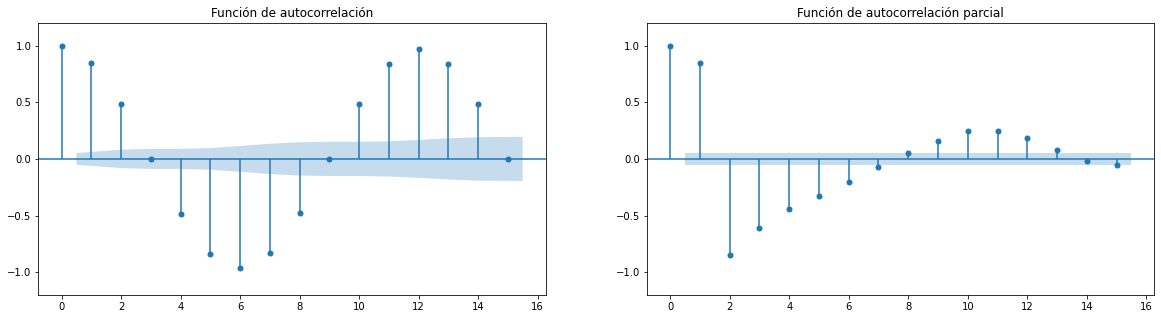


 --- Datos estacionales:

 ** Datos sin differencing

-- Test de Dickey-Fuller:
Test Statistic                -1.012837e+01
p-value                        9.054279e-18
#Lags Used                     2.400000e+01
Number of Observations Used    1.387000e+03
Critical Value (1%)           -3.435073e+00
Critical Value (5%)           -2.863626e+00
Critical Value (10%)          -2.567881e+00
dtype: float64

 ¿Continuar diferenciado?no

 ** Determinación de P y Q:


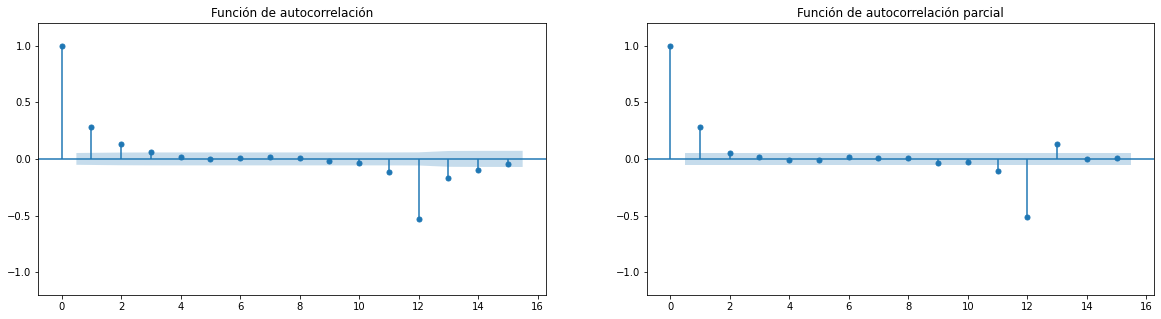


 ¿Estimamos automaticamente los parámetros del modelo?no

- parámetro p:1
- parámetro d:0
- parámetro q:0
- parámetro P:1
- parámetro D:0
- parámetro Q:2

 -- modelo SARIMA(1, 0, 0)x(1, 0, 2, 12)


/home/belen/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                              data train   No. Observations:                 1424
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -2238.599
Date:                                 Sun, 06 Mar 2022   AIC                           4487.199
Time:                                         16:35:37   BIC                           4513.505
Sample:                                     01-01-1880   HQIC                          4497.024
                                          - 08-01-1998                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3336      0.022     15.309      0.000       0.291       0

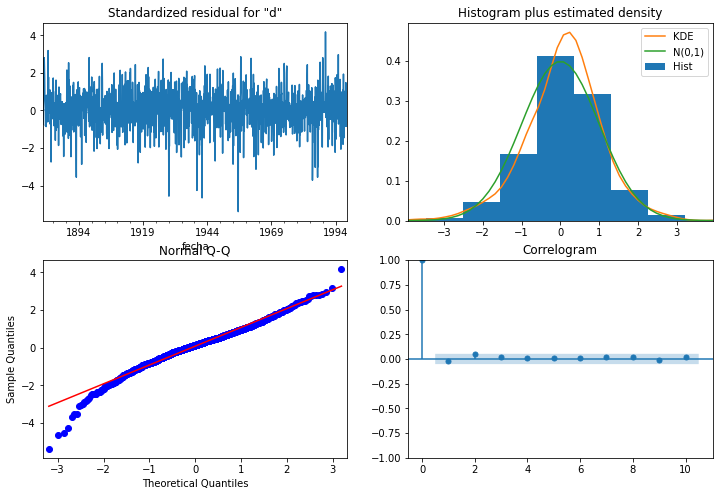


 --- Predicción de los datos:


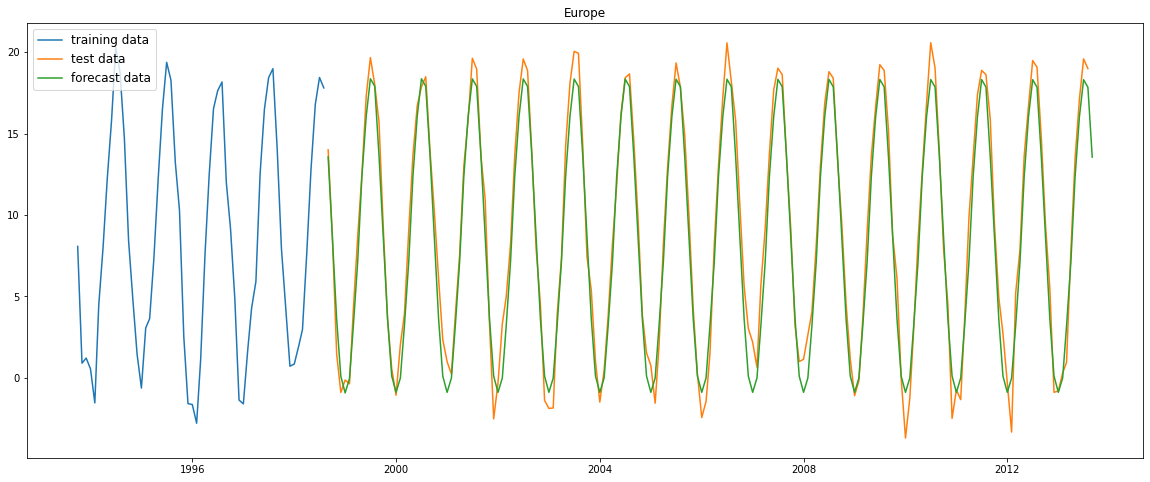

r2: 0.9654772733786562


In [32]:
data_Europe=pd.DataFrame(columns=["all data","data train","data test"])
data_Europe,model_Europe=analisis_forecasting(data,data_Europe,"Europe")

----------Asia ----------

 --- Datos observados:

 ** Datos sin differencing

-- Test de Dickey-Fuller:
Test Statistic                   -2.573404
p-value                           0.098620
#Lags Used                       23.000000
Number of Observations Used    1400.000000
Critical Value (1%)              -3.435030
Critical Value (5%)              -2.863607
Critical Value (10%)             -2.567870
dtype: float64

 ¿Hacer diferenciado?yes

 ** Primera diferencia

-- Test de Dickey-Fuller:
Test Statistic                -1.864190e+01
p-value                        2.053780e-30
#Lags Used                     2.200000e+01
Number of Observations Used    1.400000e+03
Critical Value (1%)           -3.435030e+00
Critical Value (5%)           -2.863607e+00
Critical Value (10%)          -2.567870e+00
dtype: float64

 ¿Continuar diferenciado?no

 ** Determinación de p y q:


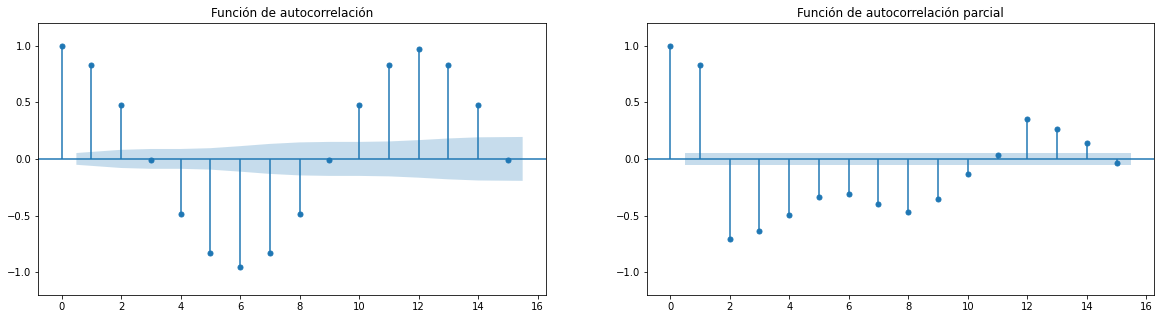


 --- Datos estacionales:

 ** Datos sin differencing

-- Test de Dickey-Fuller:
Test Statistic                -1.193135e+01
p-value                        4.773180e-22
#Lags Used                     2.400000e+01
Number of Observations Used    1.387000e+03
Critical Value (1%)           -3.435073e+00
Critical Value (5%)           -2.863626e+00
Critical Value (10%)          -2.567881e+00
dtype: float64

 ¿Continuar diferenciado?no

 ** Determinación de P y Q:


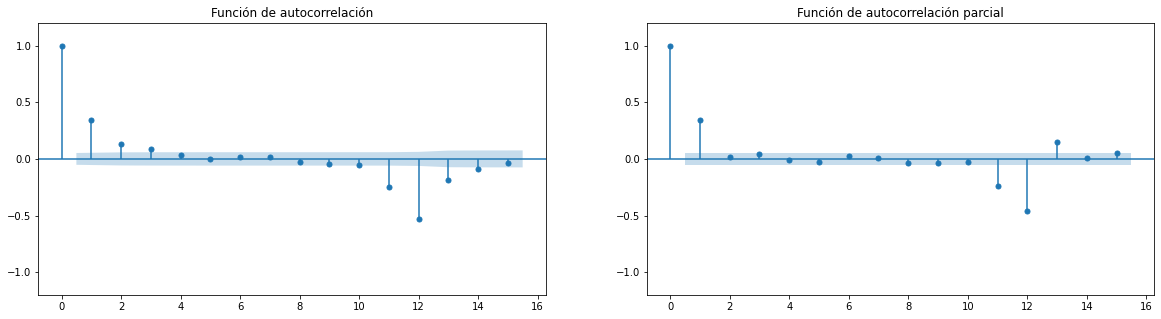


 ¿Estimamos automaticamente los parámetros del modelo?no

- parámetro p:1
- parámetro d:1
- parámetro q:2
- parámetro P:2
- parámetro D:0
- parámetro Q:2

 -- modelo SARIMA(1, 1, 2)x(2, 0, 2, 12)


/home/belen/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                         data train   No. Observations:                 1424
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 12)   Log Likelihood               -1502.116
Date:                            Sun, 06 Mar 2022   AIC                           3020.231
Time:                                    18:22:48   BIC                           3062.315
Sample:                                01-01-1880   HQIC                          3035.950
                                     - 08-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3854      0.002    165.497      0.000       0.381       0.390
ma.L1         -1.0642      0.005   

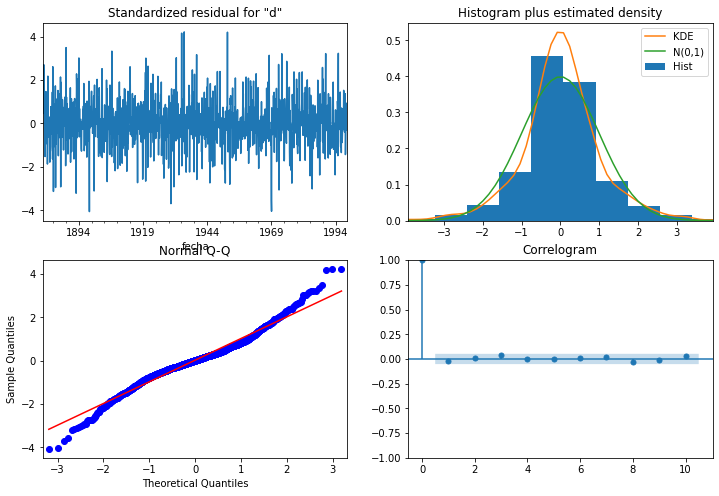


 --- Predicción de los datos:


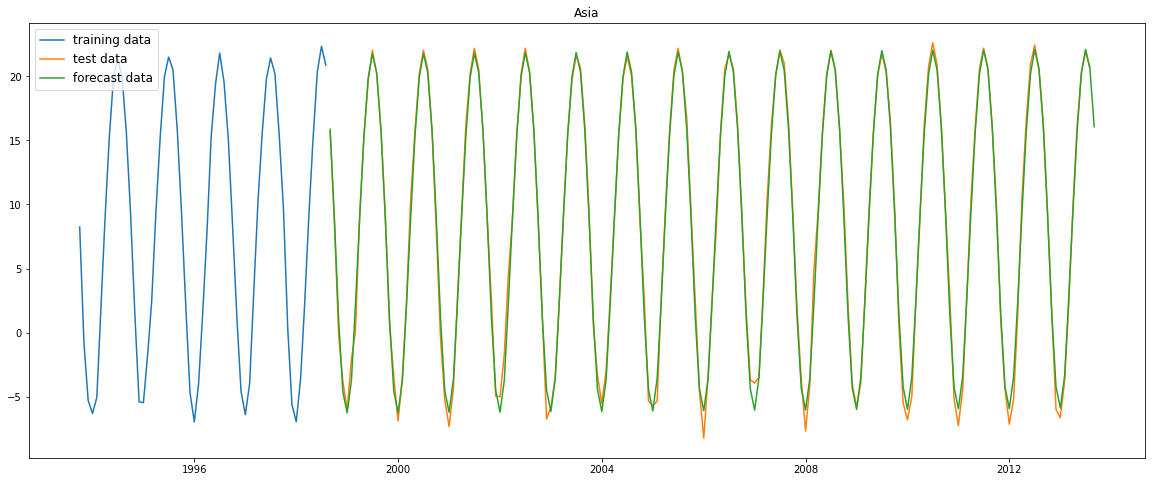

r2: 0.9941569161331947


In [40]:
data_Asia=pd.DataFrame(columns=["all data","data train","data test"])
data_Asia,model_Asia=analisis_forecasting(data,data_Asia,"Asia")

----------Africa ----------

 --- Datos observados:

 ** Datos sin differencing

-- Test de Dickey-Fuller:
Test Statistic                   -1.954814
p-value                           0.306730
#Lags Used                       24.000000
Number of Observations Used    1399.000000
Critical Value (1%)              -3.435033
Critical Value (5%)              -2.863608
Critical Value (10%)             -2.567871
dtype: float64

 ¿Hacer diferenciado?yes

 ** Primera diferencia

-- Test de Dickey-Fuller:
Test Statistic                -1.225233e+01
p-value                        9.478345e-23
#Lags Used                     2.400000e+01
Number of Observations Used    1.398000e+03
Critical Value (1%)           -3.435036e+00
Critical Value (5%)           -2.863610e+00
Critical Value (10%)          -2.567872e+00
dtype: float64

 ¿Continuar diferenciado?no

 ** Determinación de p y q:


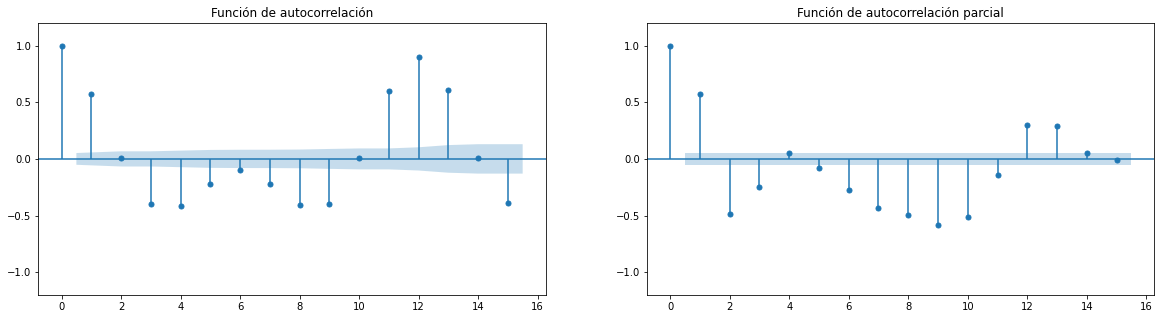


 --- Datos estacionales:

 ** Datos sin differencing

-- Test de Dickey-Fuller:
Test Statistic                -1.091051e+01
p-value                        1.100040e-19
#Lags Used                     2.400000e+01
Number of Observations Used    1.387000e+03
Critical Value (1%)           -3.435073e+00
Critical Value (5%)           -2.863626e+00
Critical Value (10%)          -2.567881e+00
dtype: float64

 ¿Continuar diferenciado?no

 ** Determinación de P y Q:


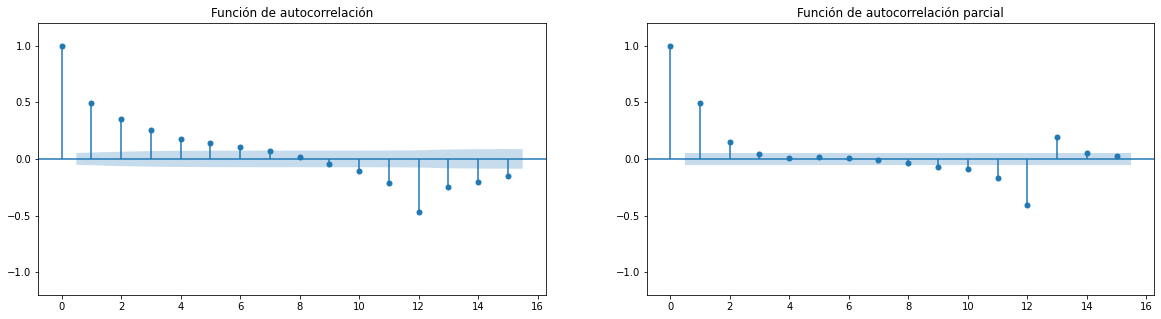


 ¿Estimamos automaticamente los parámetros del modelo?no

- parámetro p:1
- parámetro d:1
- parámetro q:2
- parámetro P:2
- parámetro D:0
- parámetro Q:1

 -- modelo SARIMA(1, 1, 2)x(2, 0, 1, 12)
                                      SARIMAX Results                                       
Dep. Variable:                           data train   No. Observations:                 1424
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 12)   Log Likelihood                -365.777
Date:                              Sun, 06 Mar 2022   AIC                            745.555
Time:                                      18:02:01   BIC                            782.378
Sample:                                  01-01-1880   HQIC                           759.309
                                       - 08-01-1998                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|     

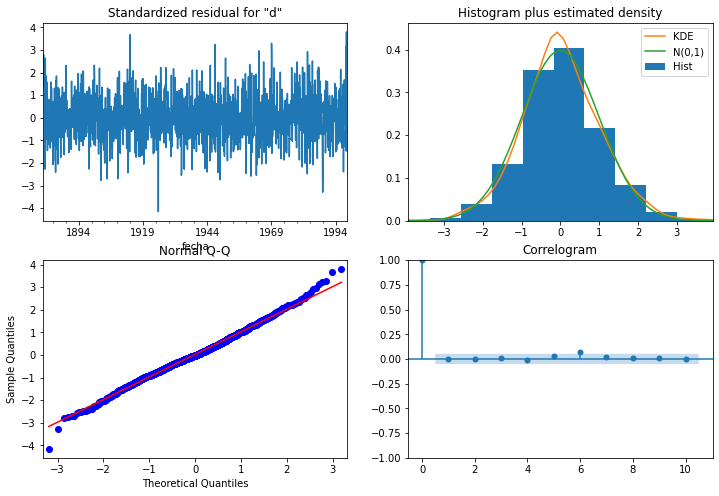


 --- Predicción de los datos:


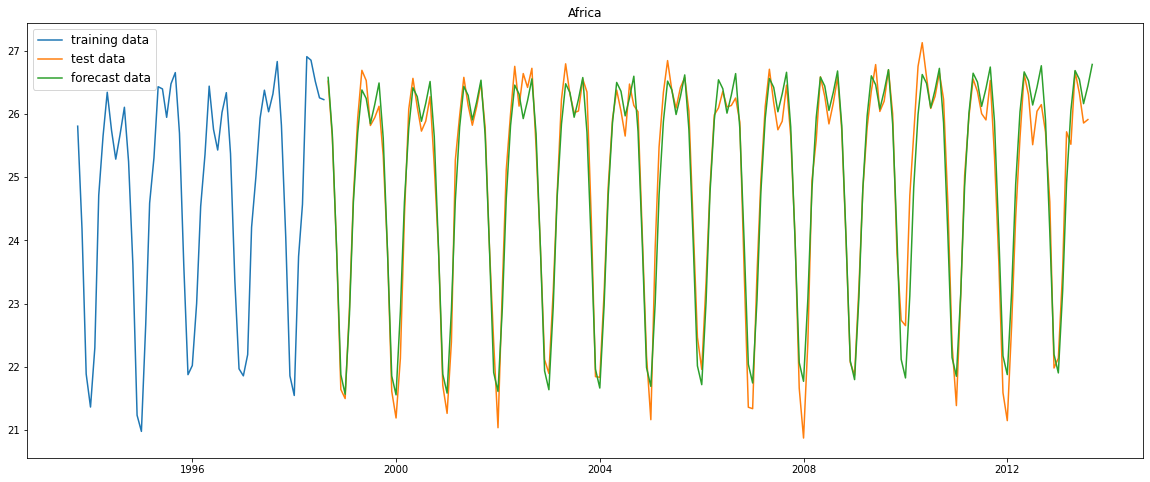

r2: 0.957159813900064


In [37]:
data_Africa=pd.DataFrame(columns=["all data","data train","data test"])

data_Africa,model_Africa=analisis_forecasting(data,data_Africa,"Africa")

----------South America ----------

 --- Datos observados:

 ** Datos sin differencing

-- Test de Dickey-Fuller:
Test Statistic                   -2.236523
p-value                           0.193258
#Lags Used                       24.000000
Number of Observations Used    1399.000000
Critical Value (1%)              -3.435033
Critical Value (5%)              -2.863608
Critical Value (10%)             -2.567871
dtype: float64

 ¿Hacer diferenciado?yes

 ** Primera diferencia

-- Test de Dickey-Fuller:
Test Statistic                -1.297710e+01
p-value                        2.996780e-24
#Lags Used                     2.300000e+01
Number of Observations Used    1.399000e+03
Critical Value (1%)           -3.435033e+00
Critical Value (5%)           -2.863608e+00
Critical Value (10%)          -2.567871e+00
dtype: float64

 ¿Continuar diferenciado?no

 ** Determinación de p y q:


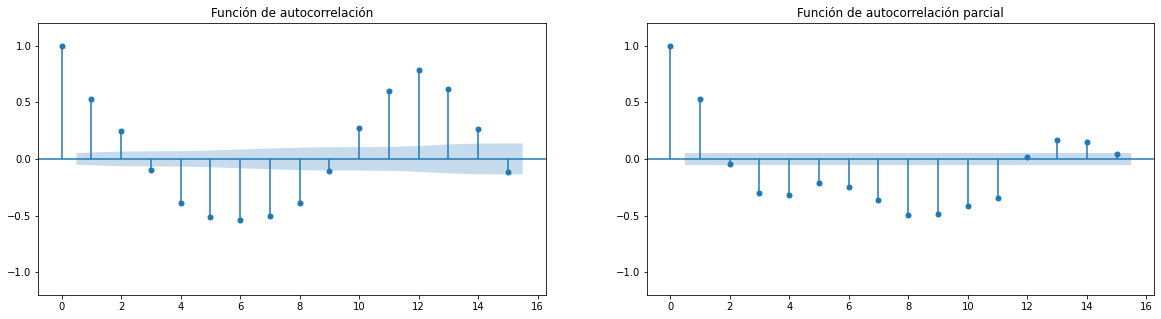


 --- Datos estacionales:

 ** Datos sin differencing

-- Test de Dickey-Fuller:
Test Statistic                -1.144485e+01
p-value                        6.053738e-21
#Lags Used                     2.400000e+01
Number of Observations Used    1.387000e+03
Critical Value (1%)           -3.435073e+00
Critical Value (5%)           -2.863626e+00
Critical Value (10%)          -2.567881e+00
dtype: float64

 ¿Continuar diferenciado?no

 ** Determinación de P y Q:


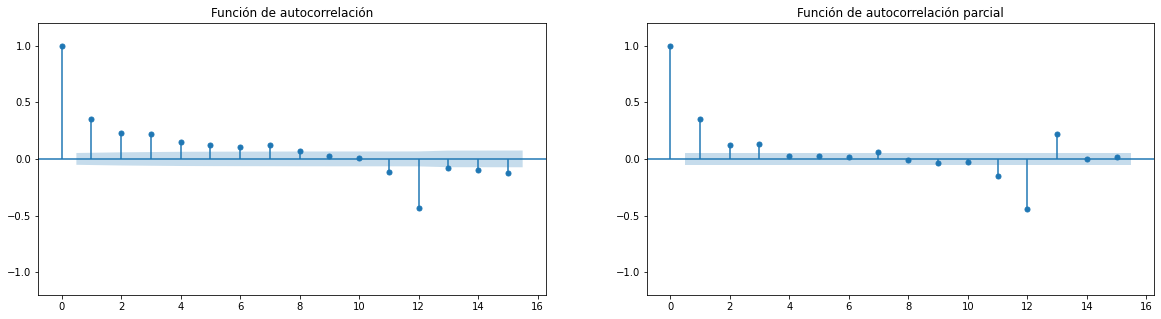


 ¿Estimamos automaticamente los parámetros del modelo?no

- parámetro p:0
- parámetro d:1
- parámetro q:1
- parámetro P:2
- parámetro D:0
- parámetro Q:1

 -- modelo SARIMA(0, 1, 1)x(2, 0, 1, 12)


/home/belen/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                         data train   No. Observations:                 1424
Model:             SARIMAX(0, 1, 1)x(2, 0, 1, 12)   Log Likelihood                -586.646
Date:                            Sun, 06 Mar 2022   AIC                           1183.291
Time:                                    16:36:36   BIC                           1209.594
Sample:                                01-01-1880   HQIC                          1193.116
                                     - 08-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7398      0.015    -48.052      0.000      -0.770      -0.710
ar.S.L12       0.9584      0.002   

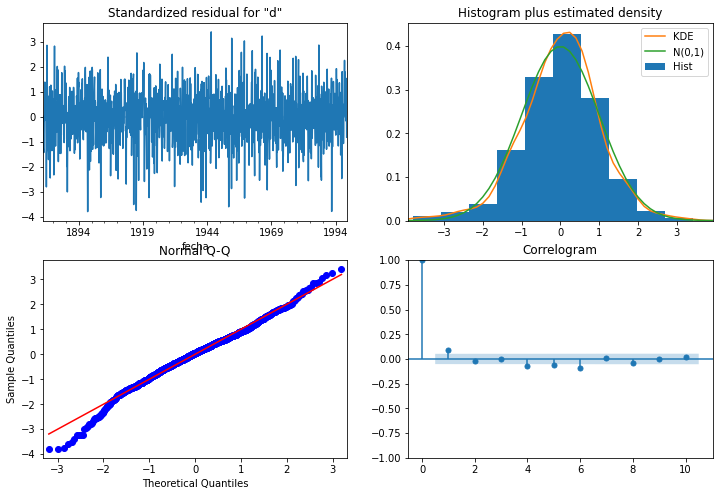


 --- Predicción de los datos:


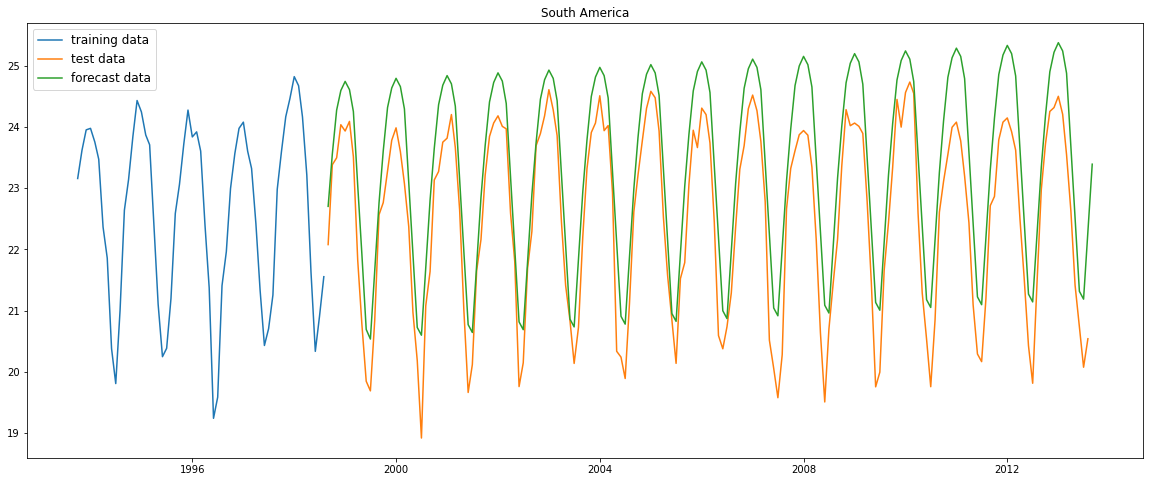

r2: 0.6551669919662908


In [33]:
data_South_America=pd.DataFrame(columns=["all data","data train","data test"])

data_South_America,model_South_America=analisis_forecasting(data,data_South_America,"South America")

----------Oceania ----------

 --- Datos observados:

 ** Datos sin differencing

-- Test de Dickey-Fuller:
Test Statistic                   -3.844683
p-value                           0.002482
#Lags Used                       23.000000
Number of Observations Used    1400.000000
Critical Value (1%)              -3.435030
Critical Value (5%)              -2.863607
Critical Value (10%)             -2.567870
dtype: float64

 ¿Hacer diferenciado?yes

 ** Primera diferencia

-- Test de Dickey-Fuller:
Test Statistic                -1.633866e+01
p-value                        3.011024e-29
#Lags Used                     2.200000e+01
Number of Observations Used    1.400000e+03
Critical Value (1%)           -3.435030e+00
Critical Value (5%)           -2.863607e+00
Critical Value (10%)          -2.567870e+00
dtype: float64

 ¿Continuar diferenciado?no

 ** Determinación de p y q:


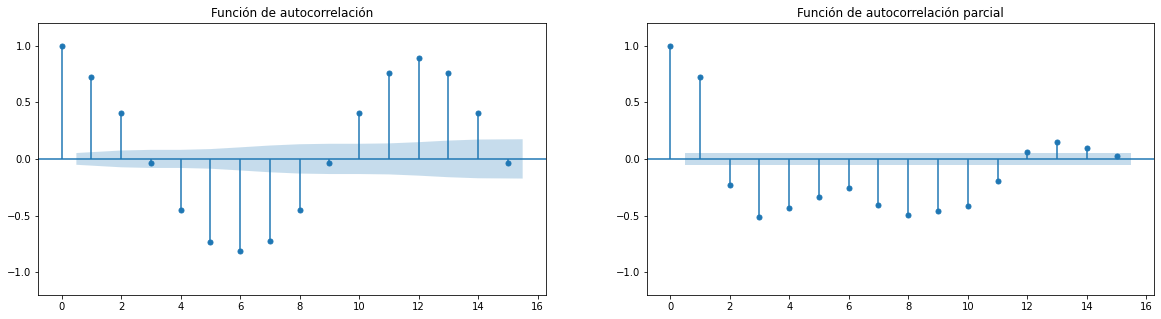


 --- Datos estacionales:

 ** Datos sin differencing

-- Test de Dickey-Fuller:
Test Statistic                -1.195480e+01
p-value                        4.234297e-22
#Lags Used                     2.400000e+01
Number of Observations Used    1.387000e+03
Critical Value (1%)           -3.435073e+00
Critical Value (5%)           -2.863626e+00
Critical Value (10%)          -2.567881e+00
dtype: float64

 ¿Continuar diferenciado?no

 ** Determinación de P y Q:


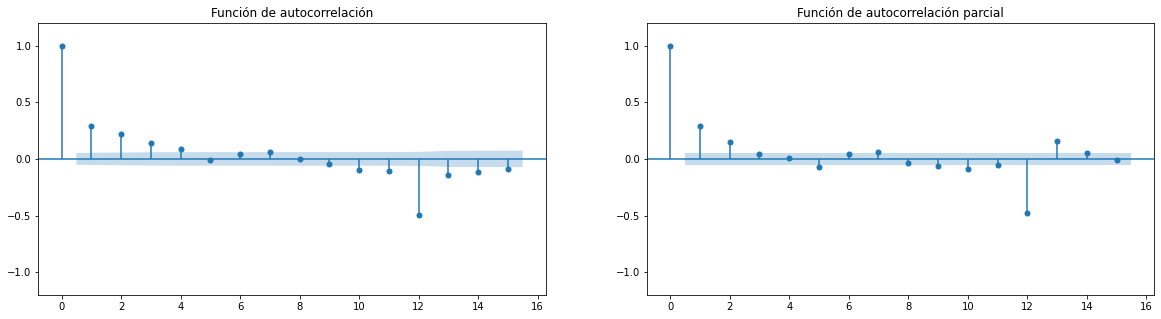


 ¿Estimamos automaticamente los parámetros del modelo?no

- parámetro p:2
- parámetro d:1
- parámetro q:1
- parámetro P:2
- parámetro D:0
- parámetro Q:1

 -- modelo SARIMA(2, 1, 1)x(2, 0, 1, 12)


/home/belen/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/belen/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/belen/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                         data train   No. Observations:                 1424
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 12)   Log Likelihood               -1449.497
Date:                            Sun, 06 Mar 2022   AIC                           2912.995
Time:                                    18:06:08   BIC                           2949.818
Sample:                                01-01-1880   HQIC                          2926.749
                                     - 08-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2801      0.025     11.084      0.000       0.231       0.330
ar.L2          0.1272      0.013   

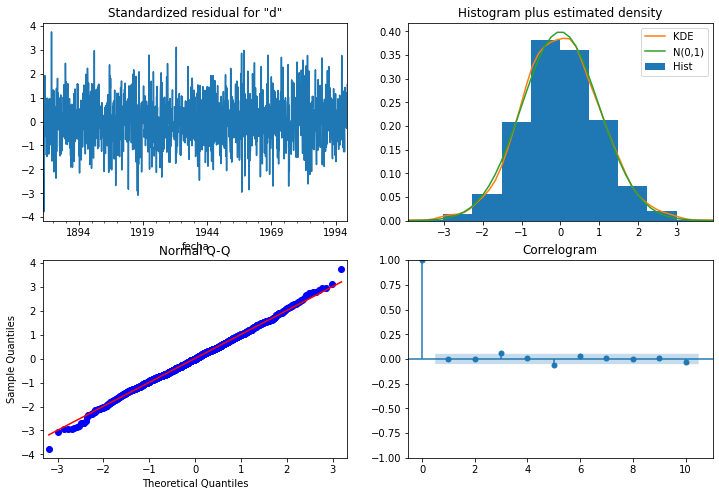


 --- Predicción de los datos:


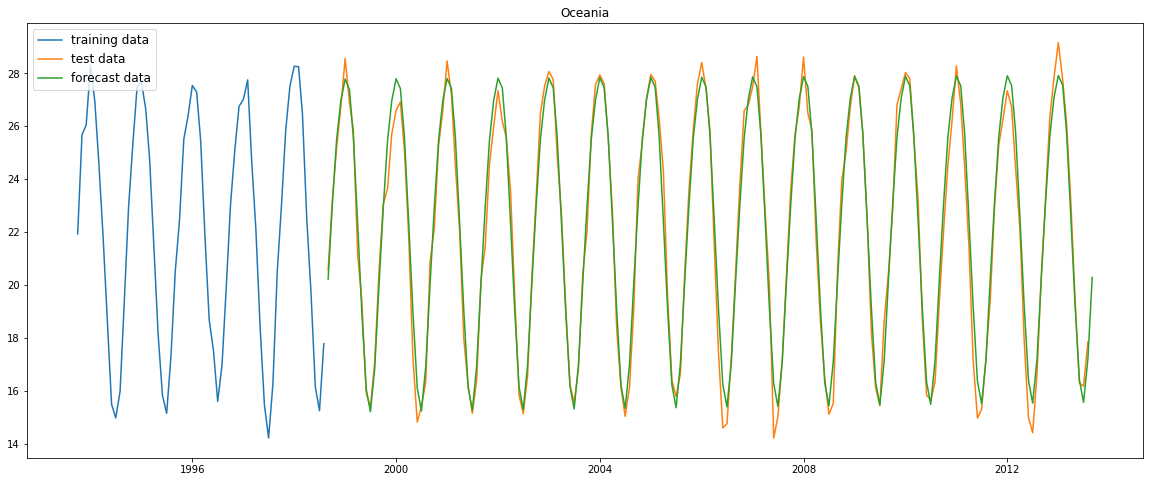

r2: 0.9735403060890566


In [39]:
data_Oceania=pd.DataFrame(columns=["all data","data train","data test"])

data_Oceania,model_Oceania=analisis_forecasting(data,data_Oceania,"Oceania")

----------North America ----------

 --- Datos observados:

 ** Datos sin differencing

-- Test de Dickey-Fuller:
Test Statistic                   -3.225664
p-value                           0.018546
#Lags Used                       24.000000
Number of Observations Used    1400.000000
Critical Value (1%)              -3.435030
Critical Value (5%)              -2.863607
Critical Value (10%)             -2.567870
dtype: float64

 ¿Hacer diferenciado?yes

 ** Primera diferencia

-- Test de Dickey-Fuller:
Test Statistic                -1.389090e+01
p-value                        5.970462e-26
#Lags Used                     2.300000e+01
Number of Observations Used    1.400000e+03
Critical Value (1%)           -3.435030e+00
Critical Value (5%)           -2.863607e+00
Critical Value (10%)          -2.567870e+00
dtype: float64

 ¿Continuar diferenciado?no

 ** Determinación de p y q:


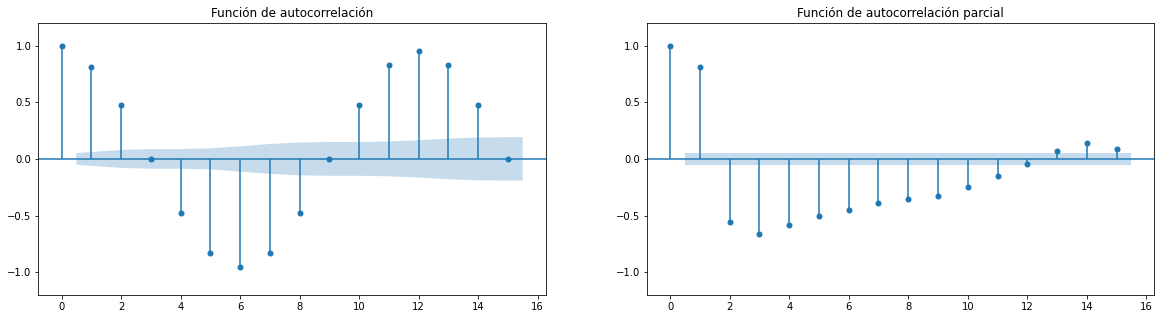


 --- Datos estacionales:

 ** Datos sin differencing

-- Test de Dickey-Fuller:
Test Statistic                -1.200640e+01
p-value                        3.256359e-22
#Lags Used                     2.400000e+01
Number of Observations Used    1.388000e+03
Critical Value (1%)           -3.435070e+00
Critical Value (5%)           -2.863625e+00
Critical Value (10%)          -2.567880e+00
dtype: float64

 ¿Continuar diferenciado?no

 ** Determinación de P y Q:


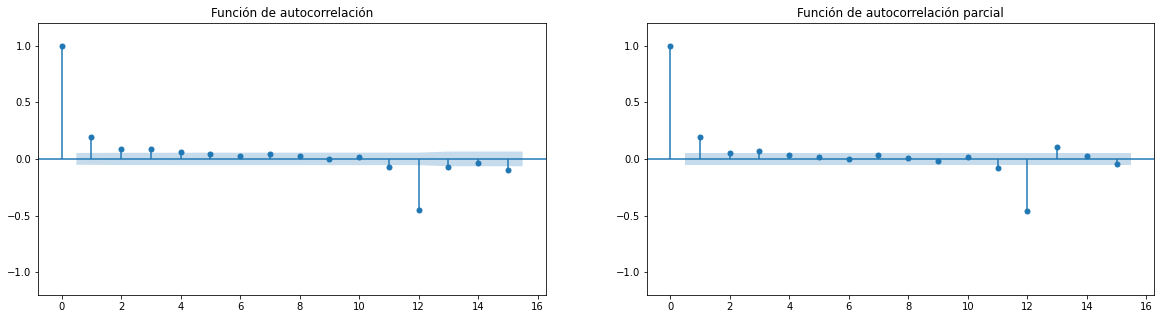


 ¿Estimamos automaticamente los parámetros del modelo?no

- parámetro p:1
- parámetro d:1
- parámetro q:2
- parámetro P:1
- parámetro D:0
- parámetro Q:1

 -- modelo SARIMA(1, 1, 2)x(1, 0, 1, 12)
                                      SARIMAX Results                                       
Dep. Variable:                           data train   No. Observations:                 1425
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1889.571
Date:                              Sun, 06 Mar 2022   AIC                           3791.143
Time:                                      18:04:46   BIC                           3822.710
Sample:                                  01-01-1880   HQIC                          3802.934
                                       - 09-01-1998                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|     

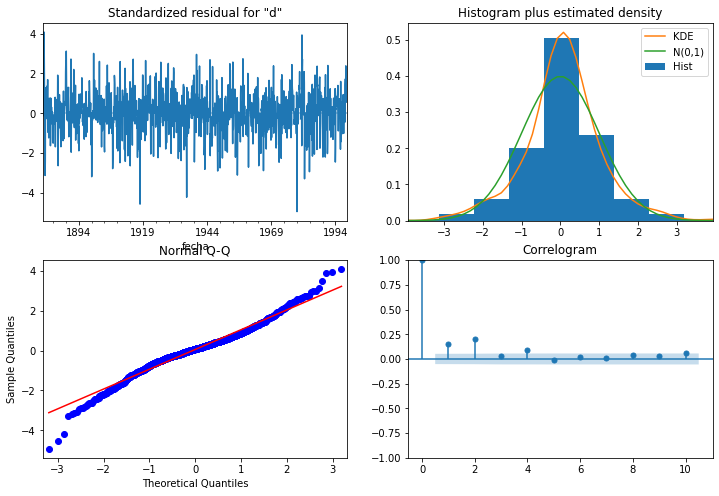


 --- Predicción de los datos:


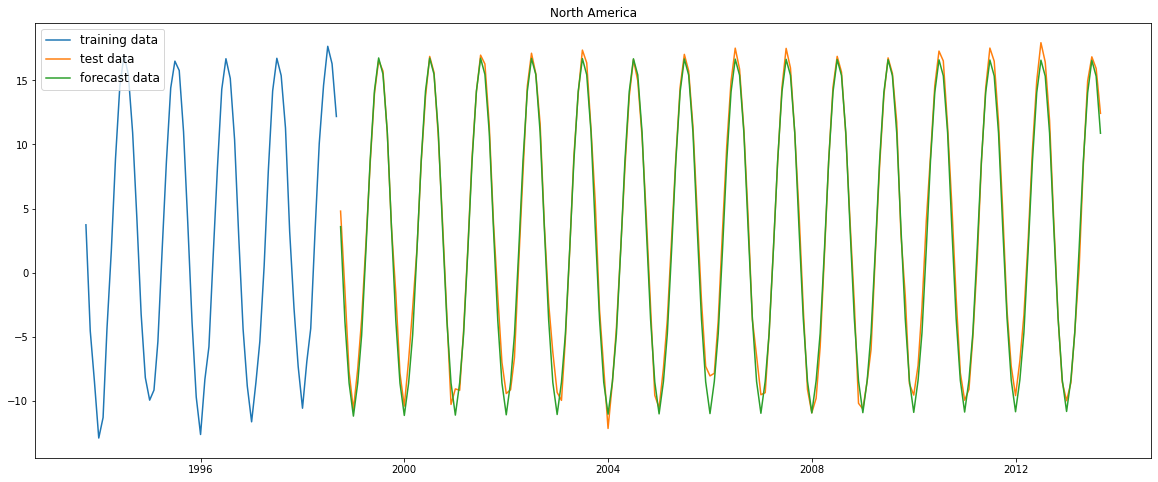

r2: 0.9896279920285654


In [38]:
data_North_America=pd.DataFrame(columns=["all data","data train","data test"])

data_North_America,model_North_America=analisis_forecasting(data,data_North_America,"North America")